# Промышленность. Предсказание температуры расплава стали

# Описание задачи
Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали.

- Критерии оценки проекта «Промышленность»

    Целевой признак: последняя измеренная температура.

    Метрика: MAE

    Критерии оценки

    - MAE > 8.7 — 0 sp
    - 7.6 < MAE ≤ 8.7 — 4 sp
    - 6.8 < MAE ≤ 7.6 — 4.5 sp
    - 6.3 < MAE ≤ 6.8 — 5 sp
    - 6.0 < MAE ≤ 6.3 — 5.5 sp
    - MAE ≤ 6.0 — 6 sp

# Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

# План работы

Предположительно наибольшее влияние на температуру будут оказывать следующие факторы (в порядке убывания значимости):\
- подача энергии через электроды, 
- подача газа, 
- сыпучие матреиалы, 
- проволока.

Основная идея объединить данные в один датафрейм с привязкой событий к общей временной шкале. Получится разреженная таблица, где одной временной метке соответствует какое-то одно событие. Для сравнимости все события в рамках каждой партии будут отсчитываться от одной точки начала.

1. Предобработка данных
- преобразование типов данных где необходимо
- объединение в общую таблицу по принципу все события для плавки в одной строке
- удаление лишних временных меток

2. EDA
- обработка пропусков и выбросов
- анализ событий в пределах цикла плавки

3. Построение моделей:
- dummy (среднее значение)
- ElasticNet (позволит сразу охватить варианты линейной регрессии Ridge, LASSO и переходные случаи)
- RandomForest
- LightGBM
- нейросеть (на Keras)


4. Анализ результатов и ошибок. Оформление выводов.

# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
#from sklearn.model_selection import RepeatedKFold, cross_val_score, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor , StackingRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import ReLU, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
# "Умная нормализация данных" - https://habr.com/ru/post/527334/
!pip install adjdatatools
from adjdatatools.preprocessing import AdjustedScaler

In [5]:
# настройка окружения
pd.options.display.max_columns=None
pd.options.display.float_format='{: .2f}'.format
sns.set(style="whitegrid")
plt.style.use('seaborn-pastel')
#plt.style.available

# Загрузка данных

In [6]:
#################################################################
PATH = '/datasets/final_steel/'
#################################################################
df_arc = pd.read_csv(PATH + 'data_arc.csv') #данные об электродах
df_bulk = pd.read_csv(PATH + 'data_bulk.csv') #данные о подаче сыпучих материалов (объём);
df_bulk_time = pd.read_csv(PATH + 'data_bulk_time.csv') #данные о подаче сыпучих материалов (время);
df_gas = pd.read_csv(PATH + 'data_gas.csv') #данные о продувке сплава газом;
df_temp = pd.read_csv(PATH + 'data_temp.csv') #результаты измерения температуры;
df_wire = pd.read_csv(PATH + 'data_wire.csv') #данные о проволочных материалах (объём);
df_wire_time = pd.read_csv(PATH + 'data_wire_time.csv') #данные о проволочных материалах (время).

In [7]:
LIST_OF_DF = ['df_temp', 'df_arc', 'df_gas', 'df_bulk', 'df_bulk_time', 'df_wire', 'df_wire_time']
for df in LIST_OF_DF:
    display(locals()[df].head(3))

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.00
1,1,2019-05-03 11:25:53,1604.00
2,1,2019-05-03 11:29:11,1618.00


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.98,0.69
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.81,0.52
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.74,0.50


,key,Газ 1
0,1,29.75
1,2,12.56
2,3,28.55


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,nan,nan,nan,43.00,nan,nan,nan,nan,nan,nan,nan,206.00,nan,150.00,154.00
1,2,nan,nan,nan,73.00,nan,nan,nan,nan,nan,nan,nan,206.00,nan,149.00,154.00
2,3,nan,nan,nan,34.00,nan,nan,nan,nan,nan,nan,nan,205.00,nan,152.00,153.00


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.06,nan,nan,nan,nan,nan,nan,nan,nan
1,2,96.05,nan,nan,nan,nan,nan,nan,nan,nan
2,3,91.16,nan,nan,nan,nan,nan,nan,nan,nan


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#df_temp.loc[df_temp['key'] == 1]

## Предобработка

In [9]:
# число партий в разных таблицах
for df in LIST_OF_DF:
    number = locals()[df]['key'].nunique()
    print(f'{df:12} ==> {number:5d}')

df_temp      ==>  3216
df_arc       ==>  3214
df_gas       ==>  3239
df_bulk      ==>  3129
df_bulk_time ==>  3129
df_wire      ==>  3081
df_wire_time ==>  3081


Итоговая таблица с признаками будет носить название - **df**

### df_temp - данные о температуре

Данные о температурах содержат целевой признак, им особое внимание. Полученная таблица будет основой к которой добавляются остальные признаки. В соответствии с поставленной задачей нас интересует только два значения: начальная и конечная температура расплава. Все промежуточные значения и партии с одним измеренным значением температуры - удаляются.

На консультации было сказано что события из таблиц: arc, bulk, wire не являются обязательными для отдельной плавки, поэтому **все последущие таблицы присоединяются методом **OUTER LEFT**

In [10]:
display(df_temp.head(3))
print('Общее число записей:', df_temp.shape[0])

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.00
1,1,2019-05-03 11:25:53,1604.00
2,1,2019-05-03 11:29:11,1618.00


Общее число записей: 15907


In [11]:
df_temp.columns = ['key', 'time', 'C_']
df_temp['time'] =  df_temp['time'].astype('datetime64') 

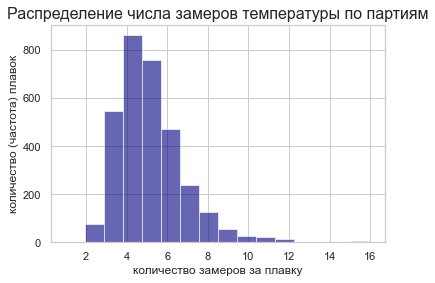

In [12]:
df_temp.groupby('key')['time'].count().plot(kind='hist', bins=16, 
                                            color='navy', alpha=0.6, grid=True);
plt.title('Распределение числа замеров температуры по партиям', fontsize=16);
plt.ylabel('количество (частота) плавок');
plt.xlabel('количество замеров за плавку');

**Информация о плавках с большим количеством измерений позволяет оценить общую динамику процесса плавки. Отобраны партии с числом измерений температуры больше 12 и построен график изменения температур по времени.**

In [13]:
print('Число плавок с числом замеров не менее 12 ==>',  end=' ')
print((df_temp.groupby('key')['time'].count() > 12).sum())
print('Число плавок с числом замеров 1 ==>',  end=' ')
print((df_temp.groupby('key')['time'].count() == 1 ).sum())

Число плавок с числом замеров не менее 12 ==> 10
Число плавок с числом замеров 1 ==> 2


**Большое число записей о плавках  - 741,  будет отброшено посколько для них доступно только одно измерение температуры.**

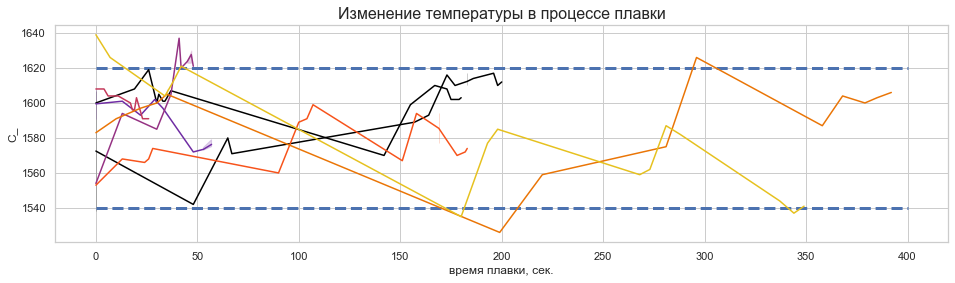

In [14]:
df_temp_index = df_temp.groupby('key')['time'].count()
temp_index = df_temp_index.loc[df_temp_index > 12].index
df_temp_graph = df_temp.loc[df_temp['key'].isin(temp_index)]
# удаление пропусков
df_temp_graph = df_temp_graph.dropna()
# удаление выбросов ниже точки плавления (1350 С)
df_temp_graph = df_temp_graph.loc[df_temp_graph['C_'] > 1350]
#df_temp_graph['start_time'] 
df_temp_graph['time_start'] = df_temp_graph.groupby('key')['time'].transform(lambda x: x.min())
df_temp_graph['duration'] = (df_temp_graph['time'] - df_temp_graph['time_start']).apply(lambda x: np.around(x.seconds/60))
plt.figure(figsize=(16, 4))
plt.title('Изменение температуры в процессе плавки', fontsize=16)
sns.lineplot(x=df_temp_graph['duration'], y=df_temp_graph['C_'], hue=df_temp_graph['key'], 
              legend=False, palette='CMRmap');
plt.hlines(1540, 0, 400, color = 'b', linewidth = 3, linestyle = '--');
plt.hlines(1620, 0, 400, color = 'b', linewidth = 3, linestyle = '--')
plt.xlabel('время плавки, сек.');

**На графике видно, что в результате каких-то воздействий (предполагаем работу электродов) температура растет и затем постепенно снижается. Температура в основном поддерживается в диапазоне 1540-1620 град. Цельсия.**

**Отбор признаков для модели**

**КОНЦЕПЦИЯ**

Итоговая температура плавки будет результатом тепловых процессов и экзо/эндотермических химических реакций происходящих в расплаве.\
Котел со сталью представляет собой объект с высокой тепловой инерционностью (вес около 100 тонн).

Исходные данные:
- работа электродов увеличивает общую энергию системы и соответственно температуру.
- присутствуют постоянные потери тепла от котла во внешнюю среду (если прекратить все воздействия, он в конце концов остынет до температуры внешней среды)
- исходная температура подаваемых материалов (газ, проволока, сыпучие материалы) ниже температуры расплава, они будут нагреваться до температуры расплава, что приведет к снижению температуры.
- газ инертный (по заявленным исходным данным), поэтому термо-химических реакций не ожидаем 
- проволока и сыпучие материалы могут вызывать экзотермические и эндотермические реакции.

осходя из принятой концепции для проволоки и сыпучих материалов создаем по два признака:
- первый будет учитывать только тепловые процессы (поглощение тепла при нагреве до температуры расплава) тут имеет значение время введения добавки, значения до начала и после окончания плавки нужно отбросить.
- второй должен отразить влияние химических реакций, этот выброс/поглощение энергии будет пропорционале массе добавки и будет иметь значение время введения до конца плавки. В этом случае события до первого измерения температуры оставляются, после окончания плавки - отбрасываются.

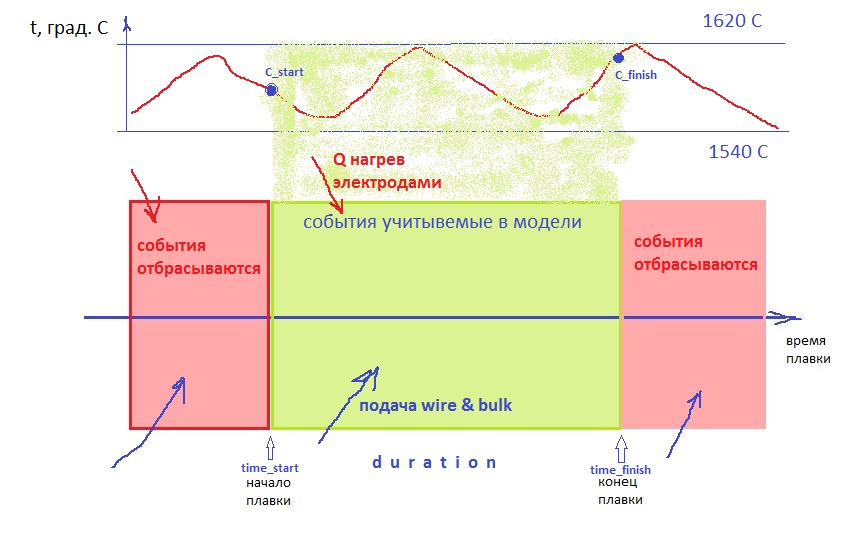

**Отбор начальных конечных температур по плавкам:**

In [15]:
# удаление возможных пропусков
df_temp = df_temp.dropna()
# отбор начальных и конечных значений
# объединение в общую таблицу
df_temp_new = df_temp.loc[df_temp.groupby('key')['time'].idxmin()].copy()
df_temp_new = df_temp_new.merge(df_temp.loc[df_temp.groupby('key')['time'].idxmax()],
                                 on='key')
df_temp_new.columns = ['key', 'time_start', 'C_start', 'time_finish', 'C_finish']
# отбрасываем данные с одним измерением
df_temp_new = df_temp_new.loc[df_temp_new['time_start'] < df_temp_new['time_finish']]
df_temp_new['duration'] = (df_temp_new['time_finish'] - df_temp_new['time_start']).apply(lambda x: x.seconds)

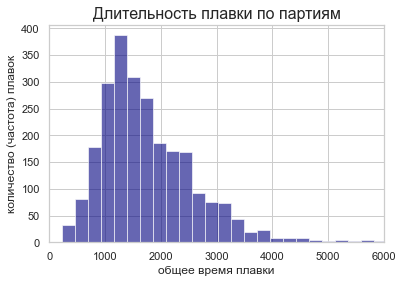

In [16]:
df_temp_new['duration'].plot(kind='hist', bins=100, 
                                            color='navy', alpha=0.6, grid=True);
plt.title('Длительность плавки по партиям', fontsize=16);
plt.xlim(0, 6000)
plt.ylabel('количество (частота) плавок');
plt.xlabel('общее время плавки');

**Создание базовой таблицы с признаками:**

In [17]:
df = df_temp_new[['key', 'C_start', 'C_finish', 'duration', 'time_start', 'time_finish']].copy()
df.head(3)

,key,C_start,C_finish,duration,time_start,time_finish
0,1,1571.00,1613.00,861,2019-05-03 11:16:18,2019-05-03 11:30:39
1,2,1581.00,1602.00,1305,2019-05-03 11:37:27,2019-05-03 11:59:12
2,3,1596.00,1599.00,1300,2019-05-03 12:13:17,2019-05-03 12:34:57


In [18]:
print('Время плавки, мин.')
df['duration'].describe()[['min', 'mean']]

Время плавки, мин.


min      234.00
mean    1854.95
Name: duration, dtype: float64

In [19]:
print('Исходное число записей:', df.shape[0])

Исходное число записей: 2475


### df_arc - данные об электродах

In [20]:
df_arc.columns=['key', 'time_start_arc', 'time_finish_arc', 'real_power', 'reactive_power']
df_arc[['time_start_arc', 'time_finish_arc']] = df_arc[['time_start_arc', 'time_finish_arc']].astype('datetime64')
# добавлен расчет полной мощности
df_arc['full_power'] = (df_arc['real_power']**2 +  df_arc['reactive_power']**2)**0.5
# добавлен показатель продолжительности работы электродов - arc_duration
df_arc['arc_duration'] = (df_arc['time_finish_arc'] - df_arc['time_start_arc']).apply(lambda x: np.around(x.seconds))
df_arc['power_intense'] = df_arc['real_power'] / df_arc['arc_duration']
df_arc.head(3)

,key,time_start_arc,time_finish_arc,real_power,reactive_power,full_power,arc_duration,power_intense
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.98,0.69,1.19,228,0.00
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.81,0.52,0.96,185,0.00
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.74,0.50,0.90,172,0.00


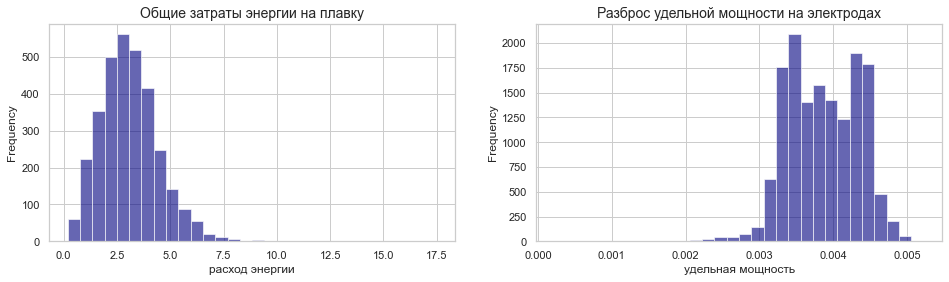

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))

df_arc.groupby('key')['real_power'].sum().plot(kind='hist', bins=30, 
                                                   color='navy', alpha=0.6, grid=True, ax=ax[0]);
                                                   
ax[0].set_title('Общие затраты энергии на плавку', fontsize=14)
ax[0].set_xlabel ('расход энергии');

df_arc['power_intense'].plot(kind='hist', bins=30, color='navy', alpha=0.6, grid=True, ax=ax[1]);
ax[1].set_title('Разброс удельной мощности на электродах', fontsize=14)
ax[1].set_xlabel ('удельная мощность');

**Отбор записей находящиеся внутри выбранного интервала измерений температуры**

In [22]:
# объединение с границами временного интервала из базовой таблицы
df_arc_v1 = df_arc.merge(df[['key', 'time_start', 'time_finish']], on='key', how='left').copy()

# отбор значений
df_arc_v1 = df_arc_v1.loc[
    (df_arc_v1['time_start_arc'] >= df_arc_v1['time_start']) &
    (df_arc_v1['time_finish_arc'] <= df_arc_v1['time_finish'])
]

In [23]:
# отобранные данные "сворачиваются" в одну запись для каждой плавки
df_arc_v2 = df_arc_v1.groupby('key')[['real_power', 'full_power', 'time_finish_arc']].agg({
            'real_power':'sum',
            'full_power':'sum',
            'time_finish_arc':'max'
}).reset_index()
# добавление данных о последнем периоде работы электродов
df_arc_v2 = df_arc_v2.merge(df_arc_v1[['key', 'time_finish_arc', 'real_power', 'arc_duration']], on=['key', 'time_finish_arc'])
df_arc_v2.columns = ['key', 'real_power', 'full_power', 'time_finish_arc', 'last_real_power', 'last_arc_duration']
df_arc_v2.head(3)

,key,real_power,full_power,time_finish_arc,last_real_power,last_arc_duration
0,1,2.35,2.78,2019-05-03 11:28:37,0.69,148
1,2,2.61,3.13,2019-05-03 11:53:18,0.83,210
2,3,1.46,1.73,2019-05-03 12:32:19,0.25,65


In [24]:
# проверка случаев работы электродов
# нагрев началмя до окончания плавки и закончился после окончания плавки
df_arc_breaked = df_arc.merge(df[['key', 'time_start', 'time_finish']], on='key', how='left').copy()

# отбор значений
df_arc_breaked_end = df_arc_breaked.loc[
    (df_arc_breaked['time_start_arc'] <= df_arc_breaked['time_finish']) &
    (df_arc_breaked['time_finish_arc'] >= df_arc_breaked['time_finish'])
]
print('число случаев работы электродов после плавки (и начало во время плавки):', df_arc_breaked_end.shape[0])

# отбор значений
df_arc_breaked_start = df_arc_breaked.loc[
    (df_arc_breaked['time_start_arc'] <= df_arc_breaked['time_start']) &
    (df_arc_breaked['time_finish_arc'] >= df_arc_breaked['time_start'])
]
print('число случаев работы электродов до плавки (и продолжение после начала):', df_arc_breaked_start.shape[0])

число случаев работы электродов после плавки (и начало во время плавки): 0
число случаев работы электродов до плавки (и продолжение после начала): 4


**Добавление полученных признаков работы электродов в итоговый df:**

In [25]:
df = df.merge(df_arc_v2, on='key', how='left')

In [26]:
# создание дополнительных признаков о работе электродов
# время между окончанием плавки и окончанием последнего цикла работы электродов
df['last_arc_time_ago']  = (df['time_finish'] - df['time_finish_arc']).apply(lambda x: x.seconds)
df['last_arc_factor'] = df['last_real_power'] / (df['last_arc_duration'] / (df['last_arc_duration'] + df['last_arc_time_ago']))
# интенсивность нагрева в течение всего срока плавки
df['power_intense'] = df['real_power'] / df['duration']
df = df.drop(['time_finish_arc'], axis=1)
df.head()

,key,C_start,C_finish,duration,time_start,time_finish,real_power,full_power,last_real_power,last_arc_duration,last_arc_time_ago,last_arc_factor,power_intense
0,1,1571.00,1613.00,861,2019-05-03 11:16:18,2019-05-03 11:30:39,2.35,2.78,0.69,148.00,122.00,1.26,0.00
1,2,1581.00,1602.00,1305,2019-05-03 11:37:27,2019-05-03 11:59:12,2.61,3.13,0.83,210.00,354.00,2.22,0.00
2,3,1596.00,1599.00,1300,2019-05-03 12:13:17,2019-05-03 12:34:57,1.46,1.73,0.25,65.00,158.00,0.86,0.00
3,4,1601.00,1625.00,388,2019-05-03 12:52:57,2019-05-03 12:59:25,1.22,1.44,1.22,278.00,95.00,1.64,0.00
4,5,1576.00,1602.00,762,2019-05-03 13:23:19,2019-05-03 13:36:01,1.89,2.25,0.27,71.00,126.00,0.74,0.00


### df_bulk @ df_bulk_time - данные о подаче сыпучих материалов

In [27]:
df_bulk.head(3)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,nan,nan,nan,43.00,nan,nan,nan,nan,nan,nan,nan,206.00,nan,150.00,154.00
1,2,nan,nan,nan,73.00,nan,nan,nan,nan,nan,nan,nan,206.00,nan,149.00,154.00
2,3,nan,nan,nan,34.00,nan,nan,nan,nan,nan,nan,nan,205.00,nan,152.00,153.00


In [28]:
# проверка целостности данных 
# каждой записи в одной таблице должна соответствовать запись в другой
print('контрольная сумма (должно быть 0):', (df_bulk.isna() != df_bulk_time.isna()).sum().sum())

контрольная сумма (должно быть 0): 0


In [29]:
# замена пробелов в названиях столбцов на '_'
def columns_rename_to_(df):
    columns_list = []
    for columns_name in df.columns:    
        columns_list.append('_'.join(columns_name.split(' '))) 
    return columns_list

df_bulk.columns = columns_rename_to_(df_bulk)
df_bulk_time.columns = columns_rename_to_(df_bulk_time)

In [30]:
#df_bulk.columns
df_bulk_columns = ['Bulk_1', 'Bulk_2', 'Bulk_3', 'Bulk_4', 'Bulk_5', 'Bulk_6',
       'Bulk_7', 'Bulk_8', 'Bulk_9', 'Bulk_10', 'Bulk_11', 'Bulk_12',
       'Bulk_13', 'Bulk_14', 'Bulk_15']

In [31]:
# преобразование типа данных в datetime
df_bulk_time[df_bulk_columns] = df_bulk_time[df_bulk_columns].astype('datetime64')

In [32]:
df_bulk_time_v2 = df_bulk_time.merge(df[['time_start', 'time_finish', 'key']], on='key', how='left').copy()


# создание объекта маски для значений попадающих в выбранный диапазон плавок
bulk_mask = df_bulk_time_v2[df_bulk_columns].apply(lambda x: 
                                         (x >= df_bulk_time_v2['time_start'])&  # до начала принятого цикла плавки
                                         (x <= df_bulk_time_v2['time_finish']) # после окончания плавки
                                                       ).copy()
df_bulk_v2 = df_bulk.copy()
df_bulk_v2[df_bulk_columns] = df_bulk[df_bulk_columns].mask(bulk_mask)
df_bulk_v2['bulk_sum'] = df_bulk_v2.drop('key', axis=1).sum(axis=1)
# df_bulk_v2 = df_bulk # вариант таблицы эквивалентный исходной без фильтров

**Добавление полученных признаков df_bulk в итоговый df:**

In [33]:
df = df.merge(df_bulk_v2, on='key', how='left')

По аналогии с признаком интенсивности для работы электродов добавляется признак интенсивности подачи сыпучих материалов **bulk_intense**:

объем поданных материолав / время плавки

In [34]:
df['bulk_intens'] = df['bulk_sum'] / df['duration']

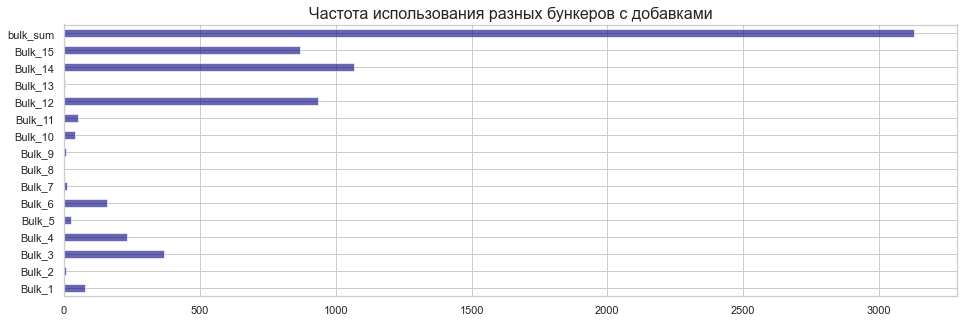

In [35]:
df_bulk_v2.drop(['key'] , axis=1).count().plot(kind='barh', grid=True,
                                                              color='navy', alpha=0.6, figsize=(16,5));
plt.title('Частота использования разных бункеров с добавками', fontsize=16);

### df_wire @ df_wire_time - данные о подаче проволок

In [36]:
df_wire.head(3)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.06,nan,nan,nan,nan,nan,nan,nan,nan
1,2,96.05,nan,nan,nan,nan,nan,nan,nan,nan
2,3,91.16,nan,nan,nan,nan,nan,nan,nan,nan


In [37]:
# проверка целостности данных 
# каждой записи в одной таблице должна соответствовать запись в другой
print('контрольная сумма (должно быть 0):', (df_wire.isna() != df_wire_time.isna()).sum().sum())

контрольная сумма (должно быть 0): 0


In [38]:
# замена пробелов в названиях столбцов на '_'
df_wire.columns = columns_rename_to_(df_wire)
df_wire_time.columns = columns_rename_to_(df_wire_time)

In [39]:
#df_wire.columns
wire_columns = ['Wire_1', 'Wire_2', 'Wire_3', 'Wire_4', 'Wire_5', 'Wire_6',
       'Wire_7', 'Wire_8', 'Wire_9']

In [40]:
# преобразование типа данных в datetime
df_wire_time[wire_columns] = df_wire_time[wire_columns].astype('datetime64')

In [41]:
df_wire_time_v2 = df_wire_time.merge(df[['time_start', 'time_finish', 'key']], on='key', how='left').copy()

# создание объекта маски для значений попадающих в выбранный диапазон плавок
wire_mask = df_wire_time_v2[wire_columns].apply(lambda x: 
                                         (x >= df_wire_time_v2['time_start'])&  # до начала принятого цикла плавки
                                         (x <= df_wire_time_v2['time_finish']) # отсечка событий после окончания плавки
                                        )
df_wire_v2 = df_wire.copy()
df_wire_v2[wire_columns] = df_wire[wire_columns].mask(wire_mask)
df_wire_v2['wire_sum'] = df_wire_v2.drop('key', axis=1).sum(axis=1)
# df_wire_v2 = df_wire

**Добавление полученных признаков df_wire в итоговый df:**

In [42]:
df = df.merge(df_wire_v2, on='key', how='left')

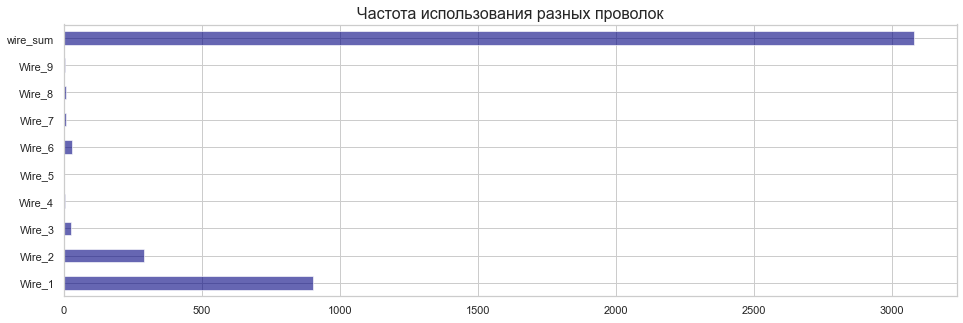

In [43]:
df_wire_v2.drop(['key'] , axis=1).count().plot(kind='barh', grid=True,
                                                              color='navy', alpha=0.6, figsize=(16,5));
plt.title('Частота использования разных проволок', fontsize=16);

### df_gas - подача газа

In [44]:
df_gas.columns = ['key', 'gas']
df_gas['key'].value_counts().max()

1

Каждой партии в таблице соответствует одно значение объема затраченного газа.

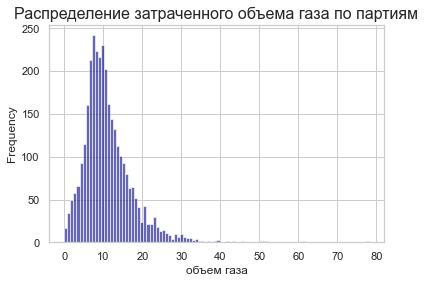

In [45]:
df_gas.groupby('key')['gas'].sum().plot(kind='hist', bins=100, color='navy', alpha=0.6, grid=True);
plt.title('Распределение затраченного объема газа по партиям', fontsize=16);
plt.xlabel('объем газа');

In [46]:
df = df.merge(df_gas, on='key', how='left')

## EDA 

### Обработка ошибок, выбросов и пропусков

#### Заполнение пропусков

In [47]:
# заполнение пропусков значением "0"
df.fillna(0, inplace=True)

#### Обработка выбросов

In [48]:
# проверка числа записей где полная мощность меньше активной (будет ошибкой)
df.loc[df['full_power'] - df['real_power'] < 0 ].shape[0]

0

**Удаление записей где начальная температура меньше температуры плавления стали - 1350 C**

In [49]:
print('Число записей начальная температура ниже температуры плавления стали: 1350 С')
print(df.loc[df['C_start'] < 1350].shape[0])

Число записей начальная температура ниже температуры плавления стали: 1350 С
4


In [50]:
df = df.loc[df['C_start'] > 1350]

**Удаление 1% плавок с большой длительностью, это случаи с другой физикой процесса.**

In [51]:
duration_limit = np.around(np.percentile(df['duration'], 99))
print('Максимальная длительность плавки по 99 перцентилю:', duration_limit, 'сек.')
print('Число случаев длительной плавки:', (df['duration'] >  duration_limit).sum()) 
df = df.loc[df['duration'] <=  duration_limit]

Максимальная длительность плавки по 99 перцентилю: 5746.0 сек.
Число случаев длительной плавки: 25


**Удаление 0.5% плавок с наименьшей длительностью**

In [52]:
duration_limit_min = np.around(np.percentile(df['duration'], 0.5))
print('Минимальная длительность плавки по 0.5 перцентилю:', duration_limit_min, 'сек.')
print('Число случаев "быстрой" плавки:', (df['duration'] <  duration_limit_min).sum()) 
df = df.loc[df['duration'] >=  duration_limit_min]

Минимальная длительность плавки по 0.5 перцентилю: 346.0 сек.
Число случаев "быстрой" плавки: 13


In [53]:
#df.describe().transpose()

### Режимы плавки

Среднее время плавки: 30.0 мин.


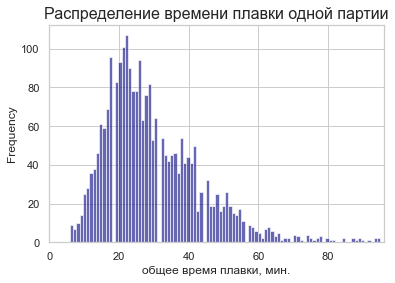

In [54]:
np.around(df['duration']/60).plot(kind='hist', bins=int(np.round(duration_limit/60)), 
                                  color='navy', alpha=0.6, grid=True);
plt.title('Распределение времени плавки одной партии', fontsize=16);
plt.xlim(0, int(np.round(duration_limit/60)))
plt.xlabel('общее время плавки, мин.');
print('Среднее время плавки:', np.around(df['duration'].mean()/60), 'мин.')

График времении плавки имеет вид нормального распределения, среднее время плавки 30 мин.

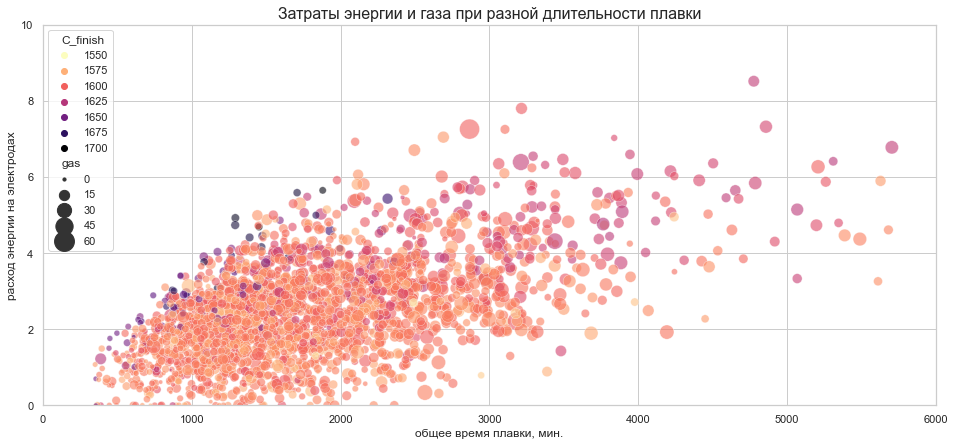

In [55]:
plt.figure(figsize=(16, 7))
plt.title('Затраты энергии и газа при разной длительности плавки', fontsize=16);
sns.scatterplot(x=df['duration'], y=df['real_power'], 
                size=df['gas'], sizes=(10, 400), 
                hue = df['C_finish'], palette='magma_r',                
                alpha=0.6
               )
plt.xlim(0, 6000)
plt.ylim(0, 10)
plt.ylabel('расход энергии на электродах');
plt.xlabel('общее время плавки, мин.');

Наибольшее влияние на конечную температуру имеет время плавки и расход энергии на электродах. Характерны большие температуры (темный цвет) для верхней кромки фигуры, где максимально отношение энергии к длительности плавки.

## Построение моделей

In [56]:
RANDOM_STATE = 210820
CPU_THREADS =  10 # число ядер CPU для расчетов

### Отбор признаков

По матрице корреляций сделан предварительный отбор созданных признаков.  Созданный **'last_arc_factor'** имеет нулевую корреляцию с целевым параметром, поэтому будет удален. Признак **'power_intense'** (отношение затраченной энергии к общей продолжительности плавки), наоборот имеет корреляцую с целевым признаком выше чем у его составляющих в отдельности, это будет полезным.

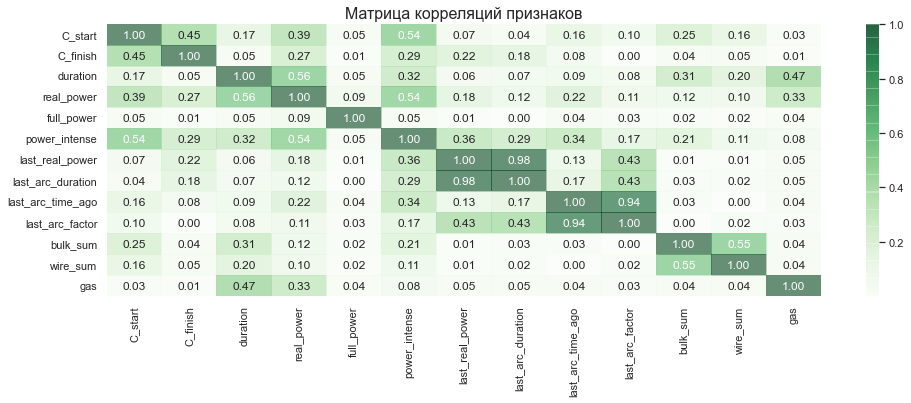

In [57]:
plt.figure(figsize=(16, 5))
sns.heatmap(df[[
    'C_start', 'C_finish', 
    'duration', 'time_start', 'time_finish',
    'real_power', 'full_power', 'power_intense',
    'last_real_power', 'last_arc_duration', 'last_arc_time_ago', 'last_arc_factor', 
    'bulk_sum', 'wire_sum',
    'gas'    
]].corr().abs(), cmap='Greens', alpha=0.6,
           annot=True, fmt='.2f'
           );
plt.title('Матрица корреляций признаков', fontsize=16);

**Среди признаков есть несколько случаев высокой мультиколлинеарности (коэф. корреляции более 0.8):**
- 'last_real_power': 'last_arc_duration' - 0.98
- 'last_arc_time_ago': 'last_arc_factor' - 0.94\
Из этих пар решено оставить только те, что имеют большие коэф. корреляции с целевым параметром:
- **'last_real_power'** - 0.22
- **'last_arc_time_ago'** - 0.08

Аналогично проведен анализ корреляций целевого параметра с сыпучими добавками и проволоками. Визуализация сделана по уже отобранным значениям. Отсутствующие параметры удалены из признаков.

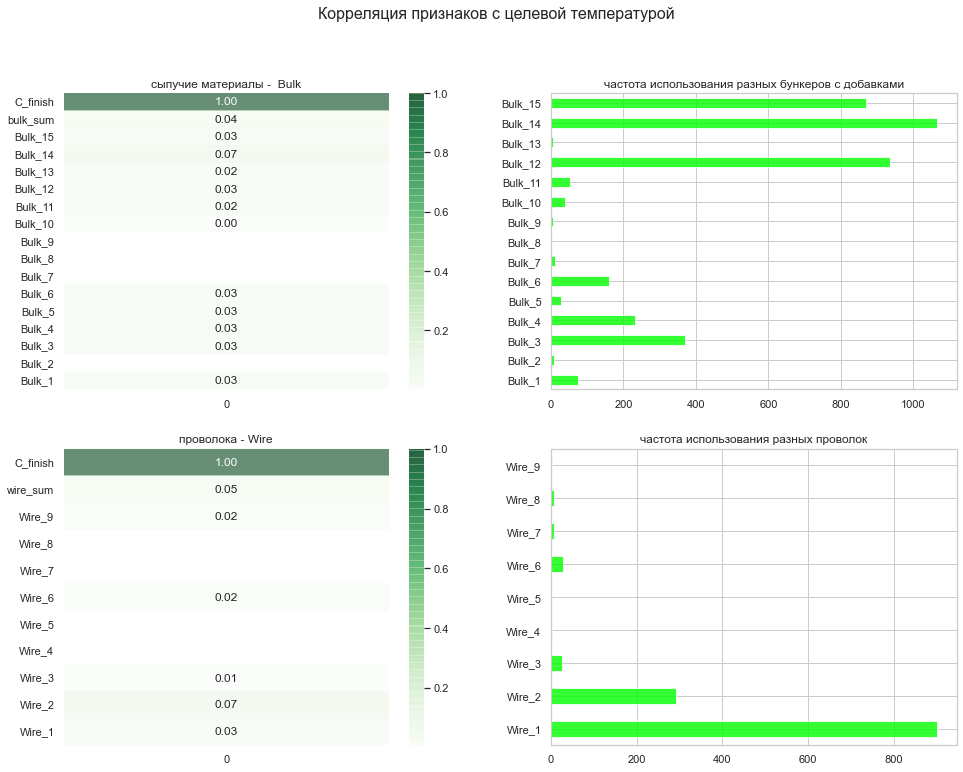

In [58]:
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
plt.suptitle('Корреляция признаков с целевой температурой', fontsize=16)
sns.heatmap(pd.DataFrame(df[[
    'C_finish', 
    'bulk_sum',   
    'Bulk_15', 'Bulk_14', 'Bulk_13', 'Bulk_12',
    'Bulk_11', 'Bulk_10', 'Bulk_9', 'Bulk_8', 
    'Bulk_7', 'Bulk_6', 'Bulk_5',   'Bulk_4', 
    'Bulk_3', 'Bulk_2', 'Bulk_1', 
    
]].corrwith(df['C_finish'], axis=0).abs()), cmap='Greens', alpha=0.6,
           annot=True, fmt='.2f', ax=ax[0,0]
           );
ax[0,0].set_title('сыпучие материалы -  Bulk')
sns.heatmap(pd.DataFrame(df[[
    'C_finish', 
    'wire_sum',
    'Wire_9', 'Wire_8','Wire_7', 'Wire_6',   
    'Wire_5', 'Wire_4', 'Wire_3', 'Wire_2', 'Wire_1',     
    
]].corrwith(df['C_finish'], axis=0).abs()), cmap='Greens', alpha=0.6,
           annot=True, fmt='.2f', ax=ax[1, 0]
           );
ax[1,0].set_title('проволока - Wire');

df_bulk_v2.drop(['key', 'bulk_sum'] , axis=1).count().plot(kind='barh', grid=True,
                                                              color='lime', alpha=0.8, ax=ax[0,1]);
ax[0,1].set_title('частота использования разных бункеров с добавками');

df_wire_v2.drop(['key', 'wire_sum'] , axis=1).count().plot(kind='barh', grid=True,
                                                              color='lime', alpha=0.8, ax=ax[1,1]);
ax[1,1].set_title('частота использования разных проволок');




**Вывод: Чем реже и меньше используется добавка, тем меньше корреляция. Решено параметры wire в модели заменить их суммой.**

**Проверка мультиколлинеарности для признаков Bulk & Wire**

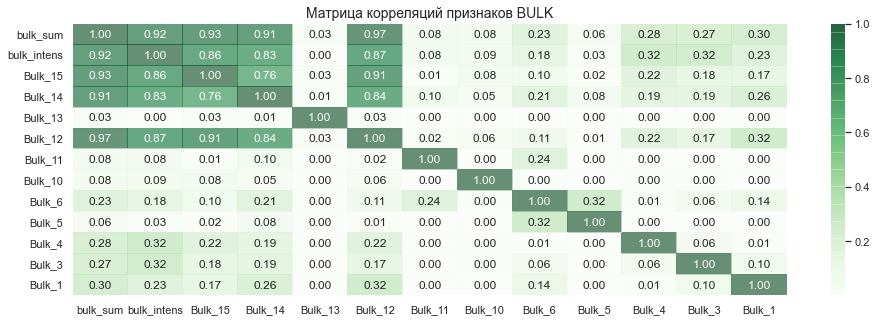

In [59]:
plt.figure(figsize=(16, 5))
sns.heatmap(df[[
            'bulk_sum', 'bulk_intens',  
            'Bulk_15', 'Bulk_14', 'Bulk_13', 'Bulk_12',
            'Bulk_11', 'Bulk_10', 
            'Bulk_6', 'Bulk_5',   'Bulk_4', 
            'Bulk_3', 'Bulk_1'     
]].corr().abs(), cmap='Greens', alpha=0.6,
           annot=True, fmt='.2f'
           );
plt.title('Матрица корреляций признаков BULK', fontsize=14);

In [60]:
df['bulk_main_12_14_15'] =  df['Bulk_12'] + df['Bulk_14'] +df['Bulk_15']
df['baulk_small'] = df['bulk_sum'] -  df['bulk_main_12_14_15'] 

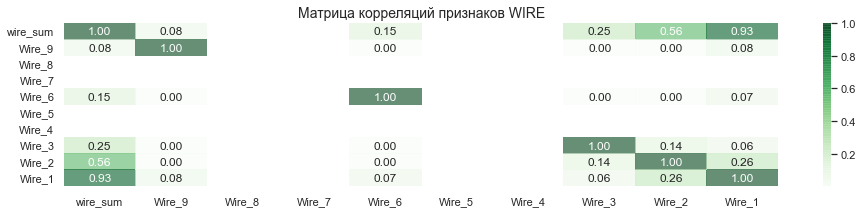

In [61]:
plt.figure(figsize=(16, 3))
sns.heatmap(df[[
            'wire_sum',
    'Wire_9', 'Wire_8','Wire_7', 'Wire_6',   
    'Wire_5', 'Wire_4', 'Wire_3', 'Wire_2', 'Wire_1'     
]].corr().abs(), cmap='Greens', alpha=0.6,
           annot=True, fmt='.2f'
           );
plt.title('Матрица корреляций признаков WIRE', fontsize=14);

**Подготовка признаков**

In [62]:
# контроль столбцов в итоговой таблице
df.columns

Index(['key', 'C_start', 'C_finish', 'duration', 'time_start', 'time_finish',
       'real_power', 'full_power', 'last_real_power', 'last_arc_duration',
       'last_arc_time_ago', 'last_arc_factor', 'power_intense', 'Bulk_1',
       'Bulk_2', 'Bulk_3', 'Bulk_4', 'Bulk_5', 'Bulk_6', 'Bulk_7', 'Bulk_8',
       'Bulk_9', 'Bulk_10', 'Bulk_11', 'Bulk_12', 'Bulk_13', 'Bulk_14',
       'Bulk_15', 'bulk_sum', 'bulk_intens', 'Wire_1', 'Wire_2', 'Wire_3',
       'Wire_4', 'Wire_5', 'Wire_6', 'Wire_7', 'Wire_8', 'Wire_9', 'wire_sum',
       'gas', 'bulk_main_12_14_15', 'baulk_small'],
      dtype='object')

**Окончательный отбор признаков и их преподготовки был проведен в несколько итераций с учетом взаимной корреляции, их значимости в полученной модели и полученной метрике.** В итоге оставлены шесть наиболее значимых.

In [63]:

X_train, X_test, y_train, y_test  = train_test_split(
                                    df[[
                                       'C_start', 
                                       'duration',
                                       'real_power', 
                                       'power_intense',
#                                       'last_real_power', 'last_arc_time_ago', 
#      'Bulk_1', 'Bulk_3',
#      'Bulk_4', 'Bulk_5', 'Bulk_6', 'Bulk_10',
#      'Bulk_11', 'Bulk_13',
#      'Bulk_12', 'Bulk_14', 'Bulk_15',
      'bulk_sum', 
#      'bulk_intens',
#      'wire_sum',     
      'gas'
                                    ]], 
                                    df['C_finish'],
                                    test_size=0.2, random_state = RANDOM_STATE)

print('=====================================')
print('Размерность датасетов')
print('=====================================')
print(' X_train  y_train  X_test   y_test')
print( X_train.shape, y_train.shape, X_test.shape,  y_test.shape )
print('=====================================')
print('Список признаков для обучения моделей')
print('=====================================')
display(X_train.columns)

Размерность датасетов
 X_train  y_train  X_test   y_test
(1946, 6) (1946,) (487, 6) (487,)
Список признаков для обучения моделей


Index(['C_start', 'duration', 'real_power', 'power_intense', 'bulk_sum',
       'gas'],
      dtype='object')

**Нормализация**\
Учитывая разнородность моделей проведена нормализация признаков со смещением. Вдохновление найдено в статье "Умная нормализация данных" - https://habr.com/ru/post/527334/. И использована библиотека **AdjustedScaler** https://github.com/newchronik/adjdatatools

In [64]:
# статья "Умная нормализация данных" - https://habr.com/ru/post/527334/
# https://github.com/newchronik/adjdatatools
smart_scaler = AdjustedScaler(with_centering=False) # опцией 'with_centering' отключено центрирование данных
smart_scaler.fit(X_train)
X_train = smart_scaler.transform(X_train)
X_test = smart_scaler.transform(X_test)

Забегая вперед можно отметить, что для всех моделей качество предсказаний моделей в области низких температур снижается. Была сделалана попытка использовать полиноминальные признаки в степени 2 для лучшей аппроксимации процессов. Выигрыша это не дало (около 0.3 на линейной регрессии и отсутствие эффекта на других моделях), поэтому в окончательном варианте не применяется.

In [65]:
# # создание полиноминального варианта признаков (степень -2 )
# polynomial_features= PolynomialFeatures(degree=2)
# X_train = polynomial_features.fit_transform(X_train)
# X_test = polynomial_features.fit_transform(X_test)

In [66]:
# функция отрисовки результатов модели (predicted)
def plot_predicted(y_test, X_test, model_name):
    df_result = pd.concat([y_test.reset_index(), 
                                    pd.Series(model_name.predict(X_test))], 
                                   axis=1).sort_values(by='C_finish').reset_index(drop=True)
    df_result.columns=['key', 'C_test', 'C_predicted']
    plt.figure(figsize=(16, 5))
    sns.scatterplot(x=df_result.index, y=df_result['C_test'],  color='navy', alpha=0.7) ;
    sns.scatterplot(x=df_result.index, y=df_result['C_predicted'],  color='red', alpha=0.5) ;
    plt.legend(['y_test', 'predicted']);

### Dummy

In [67]:
model_Dummy = DummyRegressor(strategy='median')
model_Dummy.fit(X_train, y_train)
print('=================================================')
print('Модель Dummy_median')        
print('RandomForest лучшая оценка MAE train: {:.2f}'.format(mean_absolute_error(y_train, model_Dummy.predict(X_train))))
print('RandomForest лучшая оценка MAE test: {:.2f}'.format(mean_absolute_error(y_test, model_Dummy.predict(X_test))))
# plot_predicted(y_test, X_test, model_Dummy)    
# plt.title('Dummy mean', fontsize=16);

Модель Dummy_median
RandomForest лучшая оценка MAE train: 9.75
RandomForest лучшая оценка MAE test: 9.72


### ElasticNet

In [68]:
# Модель регрессии ElasticNet
def grid_elastic(X_train, y_train):
    model = ElasticNet(random_state=RANDOM_STATE)
    
    # вариация параметра l1_ratio позволяет испытать разные модели штрафов: 
    # 0 - Grid, 1 - Lasso, и все промежуточные значения это Elastic
    params = {   
                 'l1_ratio': [0.01, 0.4, 0.5, 0.6, 0.9, 0.99],
                 'alpha':[0.01]
                 
    } 
    
    grid = GridSearchCV(model, params, 
                        cv=4, scoring='neg_mean_absolute_error', 
                        verbose=True, n_jobs=CPU_THREADS)
    
    # добавлен параметр samle_weight чтобы повысить значимость образцов с высоким дебетом
    grid.fit(X_train, y_train)
    return grid

model_ElasticNet = grid_elastic(X_train, y_train)
print('ElasticNet лучшие параметры:', model_ElasticNet.best_params_)
print('ElasticNet лучшая оценка MAE train: {:.2f}'.format(model_ElasticNet.best_score_))
print('ElasticNet лучшая оценка MAE test: {:.2f}'.format(
             mean_absolute_error(y_test, model_ElasticNet.predict(X_test))))

Fitting 4 folds for each of 6 candidates, totalling 24 fits
ElasticNet лучшие параметры: {'alpha': 0.01, 'l1_ratio': 0.99}
ElasticNet лучшая оценка MAE train: -6.22
ElasticNet лучшая оценка MAE test: 6.36


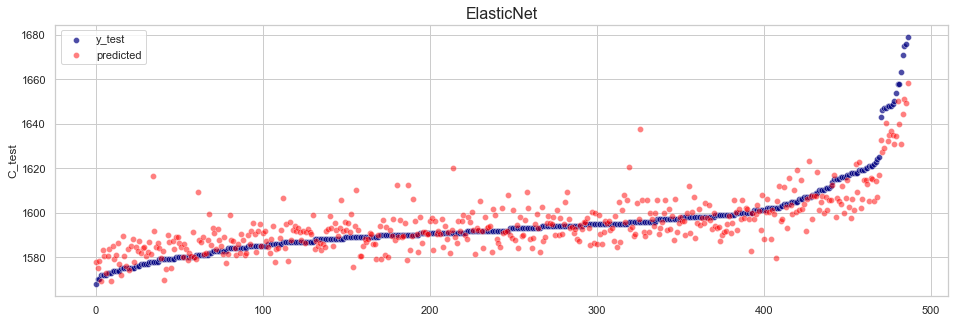

In [69]:
plot_predicted(y_test, X_test, model_ElasticNet)    
plt.title('ElasticNet', fontsize=16);

### ElasticNet_Poly

In [70]:
# создание полиноминального варианта признаков (степень - 2)
polynomial_features= PolynomialFeatures(degree=2)
polynomial_features.fit(X_train)
X_train_poly = polynomial_features.transform(X_train)
X_test_poly = polynomial_features.transform(X_test)

In [71]:
# Модель регрессии ElasticNet полиноминальная

model_ElasticNet_Poly = grid_elastic(X_train_poly, y_train)
print('ElasticNet лучшие параметры:', model_ElasticNet_Poly.best_params_)
print('ElasticNet лучшая оценка MAE train: {:.2f}'.format(model_ElasticNet_Poly.best_score_))
print('ElasticNet лучшая оценка MAE test: {:.2f}'.format(
             mean_absolute_error(y_test, model_ElasticNet_Poly.predict(X_test_poly))))

Fitting 4 folds for each of 6 candidates, totalling 24 fits
ElasticNet лучшие параметры: {'alpha': 0.01, 'l1_ratio': 0.99}
ElasticNet лучшая оценка MAE train: -5.66
ElasticNet лучшая оценка MAE test: 5.72


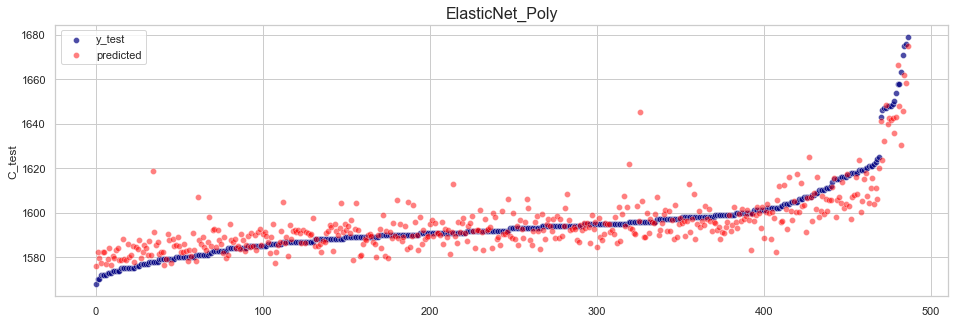

In [72]:
plot_predicted(y_test, X_test_poly, model_ElasticNet_Poly)    
plt.title('ElasticNet_Poly', fontsize=16);

**Полиноминальная регрессия лучше линейной предсказывает значения при низких температурах.**

In [73]:
#X_test.merge((y_test - model_ElasticNet_Poly.predict(X_test_poly)) )

### RandomForestRegressor

Для экономии времени перебор параметров ограничен вокруг оптимума

In [74]:
%%time
RF = RandomForestRegressor(random_state = RANDOM_STATE)

params_RF = {    
    'max_depth': range(14, 20, 2),
    'n_estimators': range(140, 171, 10),
    'min_samples_leaf' : [2]   
}

model_RandomForest = GridSearchCV(RF, params_RF, 
                                  scoring = 'neg_mean_absolute_error',
                                  cv=5, return_train_score=True,  
                                  n_jobs=CPU_THREADS, verbose=1)

model_RandomForest.fit(X_train, y_train)
print('Модель RandomForestRegressor')        
print('лучшие параметры:', model_RandomForest.best_params_)
print('RandomForest лучшая оценка MAE train: {:.2f}'.format(model_RandomForest.best_score_))
print('RandomForest лучшая оценка MAE test: {:.2f}'.format(mean_absolute_error(y_test, model_RandomForest.predict(X_test))))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Модель RandomForestRegressor
лучшие параметры: {'max_depth': 14, 'min_samples_leaf': 2, 'n_estimators': 160}
RandomForest лучшая оценка MAE train: -5.95
RandomForest лучшая оценка MAE test: 5.93
Wall time: 5.63 s


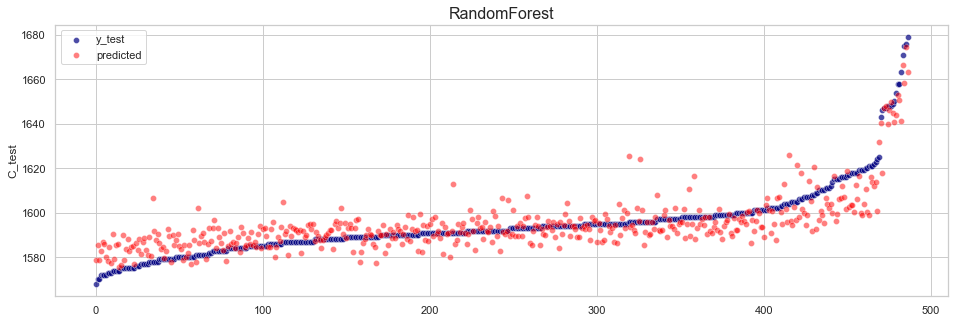

In [75]:
plot_predicted(y_test, X_test, model_RandomForest)    
plt.title('RandomForest', fontsize=16);

### LGBM

Подбор гиперпараметров выполнялся через GridSearchCV на сокращенной выборке, обучение на всей выборке train напрямую в lightgbm (дает лучший результат чем через lightgbm.sklearn)

In [76]:
%%time
# подбор гиперпараметров lightgbm на уменьшенной выборке

lgbm = LGBMRegressor(random_state=RANDOM_STATE)
params_lgbm = { 
    'objective': ['regression'],
    'boosting_type': ['gbdt'],
    'max_depth': range(10, 11, 10),    
    'num_leaves': range(30, 41, 10),
    'min_data_in_leaf': range(12, 15, 1),   
    'max_bin': range(80, 121, 10),
    'learning_rate': [0.01, 0.02, 0.05],
}    

model_lgbm = GridSearchCV(lgbm, params_lgbm, cv=6, scoring='neg_mean_absolute_error',
                          verbose=1, n_jobs=CPU_THREADS)                 
model_lgbm.fit(X_train, y_train)
display(model_lgbm.best_params_, model_lgbm.best_score_)      

Fitting 6 folds for each of 90 candidates, totalling 540 fits
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14


{'boosting_type': 'gbdt',
 'learning_rate': 0.05,
 'max_bin': 80,
 'max_depth': 10,
 'min_data_in_leaf': 14,
 'num_leaves': 30,
 'objective': 'regression'}

-5.809321677619555

Wall time: 3.89 s


Модель LightGBM
LightGBM лучшая оценка MAE train: -5.81
LightGBM лучшая оценка MAE test: 5.73


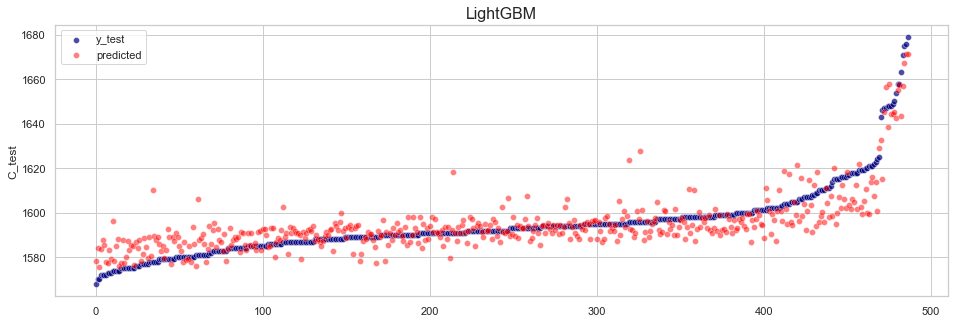

In [77]:
print('=================================================')
print('Модель LightGBM')
print('LightGBM лучшая оценка MAE train: {:.2f}'.format(model_lgbm.best_score_))
print('LightGBM лучшая оценка MAE test: {:.2f}'.format(mean_absolute_error(y_test, model_lgbm.predict(X_test))))
plot_predicted(y_test, X_test, model_lgbm)    
plt.title('LightGBM', fontsize=16);

### Stacking

Модель StackingRegressor
StackingRegressor лучшая оценка MAE train: 2.87
StackingRegressor лучшая оценка MAE test: 5.86


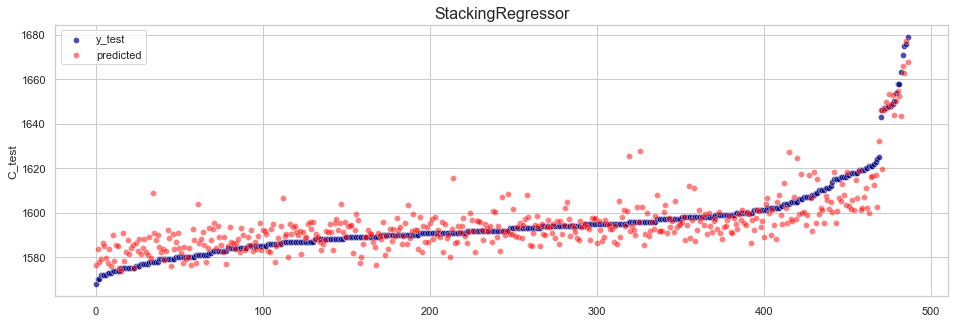

In [78]:
estimators = [
         ('ElasticNet', ElasticNet(random_state=RANDOM_STATE)),
         ('LightGBM', LGBMRegressor(random_state=RANDOM_STATE)),
         ('RF', RandomForestRegressor(random_state=RANDOM_STATE)),
        
]
  

model_Stacking = StackingRegressor(
     estimators=estimators,
     cv=5,
     #final_estimator=RandomForestRegressor(n_estimators=10, random_state=RANDOM_STATE)
)

model_Stacking.fit(X_train, y_train)#.score(X_test, y_test)


print('=================================================')
print('Модель StackingRegressor')
print('StackingRegressor лучшая оценка MAE train: {:.2f}'.format(mean_absolute_error(y_train, model_Stacking.predict(X_train))))
print('StackingRegressor лучшая оценка MAE test: {:.2f}'.format(mean_absolute_error(y_test, model_Stacking.predict(X_test))))
plot_predicted(y_test, X_test, model_Stacking)    
plt.title('StackingRegressor', fontsize=16);

### Нейросеть

Нейросеть используется для стэкинга моделей ElasticNet и RandomForest. На вход подаются стандандартные признаки + предсказания   указанных моделей, предполагается что нейросеть отберет лучшее приближение исходя из остальных данных.

In [79]:
features_train, features_val = train_test_split(X_train, test_size=0.2, random_state=RANDOM_STATE)
target_train, target_val = train_test_split(y_train, test_size=0.2, random_state=RANDOM_STATE)

In [80]:
def add_predicted_to_features(df):
    features = df.copy()
    features['ElasticNet']  = model_ElasticNet.predict(df)
    features['RandomForest'] = model_RandomForest.predict(df)
    return features

features_train = add_predicted_to_features(features_train)
features_val = add_predicted_to_features(features_val)


In [81]:
mae = tf.keras.losses.MeanAbsoluteError()
def create_model(input_shape, learning_rate):
    
    optimizer = Adam(lr=learning_rate)
    
    model = Sequential()    
    model.add(Dense(100, input_dim=input_shape, activation='relu'))
    model.add(Dense(50, activation='relu'))
    
#    model.add(Dense(20, activation='relu'))

    model.add(Dense(1, activation='linear'))   

    model.compile(optimizer=optimizer, 
                loss= mae,
                  
                metrics=[mae])
    return model


model = create_model(X_test.shape[1] + 2, 0.00002)
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               900       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 6,001
Trainable params: 6,001
Non-trainable params: 0
_________________________________________________________________


In [82]:
###################################
### Обучение модели
###################################
def train_model(model, train_data, test_data, epochs=1):


#         
#                               early_stopping =EarlyStopping(
#                               monitor='val_loss', 
#                               patience=20,
#                               restore_best_weights=True)

#         filepath= PATH + 'improvement-{val_loss:.2f}-{epoch:02d}.hdf5'

#         model_checkpoint = ModelCheckpoint(filepath,
#                                            monitor='val_loss', 
#                                            save_weights_only=True,
#                                            verbose=0, 
#                                            save_best_only=True, 
#                                            mode='min', 
#                                            #save_freq='epoch'
#                                            )

        history = model.fit(features_train, target_train,
                validation_data=(features_val, target_val),
                epochs=epochs,
                verbose=2, 
                shuffle=True,            
                #callbacks=[model_checkpoint]
            )

        return model, history
#############################################################################
model_Keras, history = train_model(model, X_train, X_test, 500)

Train on 1556 samples, validate on 390 samples
Epoch 1/500
1556/1556 - 0s - loss: 1781.6205 - mean_absolute_error: 1781.3036 - val_loss: 1737.4299 - val_mean_absolute_error: 1737.2717
Epoch 2/500
1556/1556 - 0s - loss: 1693.7404 - mean_absolute_error: 1693.4532 - val_loss: 1650.1841 - val_mean_absolute_error: 1649.7401
Epoch 3/500
1556/1556 - 0s - loss: 1608.4657 - mean_absolute_error: 1608.1986 - val_loss: 1566.6552 - val_mean_absolute_error: 1567.4711
Epoch 4/500
1556/1556 - 0s - loss: 1524.6874 - mean_absolute_error: 1524.3354 - val_loss: 1480.6831 - val_mean_absolute_error: 1480.4197
Epoch 5/500
1556/1556 - 0s - loss: 1434.8451 - mean_absolute_error: 1434.5242 - val_loss: 1389.3224 - val_mean_absolute_error: 1389.5303
Epoch 6/500
1556/1556 - 0s - loss: 1345.3290 - mean_absolute_error: 1344.9996 - val_loss: 1300.8185 - val_mean_absolute_error: 1301.5699
Epoch 7/500
1556/1556 - 0s - loss: 1256.8024 - mean_absolute_error: 1256.4562 - val_loss: 1212.0417 - val_mean_absolute_error: 1211

Epoch 65/500
1556/1556 - 0s - loss: 4.2102 - mean_absolute_error: 4.2017 - val_loss: 4.0042 - val_mean_absolute_error: 4.2914
Epoch 66/500
1556/1556 - 0s - loss: 4.1901 - mean_absolute_error: 4.1868 - val_loss: 3.9433 - val_mean_absolute_error: 3.8269
Epoch 67/500
1556/1556 - 0s - loss: 4.1865 - mean_absolute_error: 4.1896 - val_loss: 3.8703 - val_mean_absolute_error: 4.0652
Epoch 68/500
1556/1556 - 0s - loss: 4.1558 - mean_absolute_error: 4.1501 - val_loss: 3.9425 - val_mean_absolute_error: 4.1254
Epoch 69/500
1556/1556 - 0s - loss: 4.1553 - mean_absolute_error: 4.1702 - val_loss: 4.3559 - val_mean_absolute_error: 4.3309
Epoch 70/500
1556/1556 - 0s - loss: 4.1926 - mean_absolute_error: 4.1941 - val_loss: 3.8704 - val_mean_absolute_error: 4.0026
Epoch 71/500
1556/1556 - 0s - loss: 4.1487 - mean_absolute_error: 4.1478 - val_loss: 3.8795 - val_mean_absolute_error: 3.9050
Epoch 72/500
1556/1556 - 0s - loss: 4.1704 - mean_absolute_error: 4.1633 - val_loss: 4.1244 - val_mean_absolute_error:

Epoch 130/500
1556/1556 - 0s - loss: 4.1343 - mean_absolute_error: 4.1276 - val_loss: 3.8366 - val_mean_absolute_error: 3.8115
Epoch 131/500
1556/1556 - 0s - loss: 4.1994 - mean_absolute_error: 4.1937 - val_loss: 3.8708 - val_mean_absolute_error: 3.7584
Epoch 132/500
1556/1556 - 0s - loss: 4.2153 - mean_absolute_error: 4.2130 - val_loss: 3.8425 - val_mean_absolute_error: 3.7864
Epoch 133/500
1556/1556 - 0s - loss: 4.0934 - mean_absolute_error: 4.0930 - val_loss: 3.9162 - val_mean_absolute_error: 3.9498
Epoch 134/500
1556/1556 - 0s - loss: 4.0985 - mean_absolute_error: 4.1066 - val_loss: 3.8335 - val_mean_absolute_error: 4.2506
Epoch 135/500
1556/1556 - 0s - loss: 4.2691 - mean_absolute_error: 4.2672 - val_loss: 3.8604 - val_mean_absolute_error: 3.8206
Epoch 136/500
1556/1556 - 0s - loss: 4.0763 - mean_absolute_error: 4.0616 - val_loss: 3.8589 - val_mean_absolute_error: 3.8010
Epoch 137/500
1556/1556 - 0s - loss: 4.1210 - mean_absolute_error: 4.1169 - val_loss: 3.8313 - val_mean_absolut

Epoch 195/500
1556/1556 - 0s - loss: 4.0931 - mean_absolute_error: 4.1035 - val_loss: 3.8137 - val_mean_absolute_error: 3.8118
Epoch 196/500
1556/1556 - 0s - loss: 4.0790 - mean_absolute_error: 4.0779 - val_loss: 3.7838 - val_mean_absolute_error: 3.7267
Epoch 197/500
1556/1556 - 0s - loss: 4.0868 - mean_absolute_error: 4.0831 - val_loss: 3.9135 - val_mean_absolute_error: 3.8267
Epoch 198/500
1556/1556 - 0s - loss: 4.0917 - mean_absolute_error: 4.0954 - val_loss: 3.8546 - val_mean_absolute_error: 4.0882
Epoch 199/500
1556/1556 - 0s - loss: 4.1016 - mean_absolute_error: 4.0989 - val_loss: 4.0694 - val_mean_absolute_error: 3.9588
Epoch 200/500
1556/1556 - 0s - loss: 4.0847 - mean_absolute_error: 4.0840 - val_loss: 3.8158 - val_mean_absolute_error: 3.8313
Epoch 201/500
1556/1556 - 0s - loss: 4.0480 - mean_absolute_error: 4.0445 - val_loss: 4.1539 - val_mean_absolute_error: 4.0958
Epoch 202/500
1556/1556 - 0s - loss: 4.0838 - mean_absolute_error: 4.0765 - val_loss: 3.7843 - val_mean_absolut

Epoch 260/500
1556/1556 - 0s - loss: 4.0392 - mean_absolute_error: 4.0240 - val_loss: 3.7827 - val_mean_absolute_error: 3.8304
Epoch 261/500
1556/1556 - 0s - loss: 3.9918 - mean_absolute_error: 3.9948 - val_loss: 3.7331 - val_mean_absolute_error: 3.7886
Epoch 262/500
1556/1556 - 0s - loss: 4.0289 - mean_absolute_error: 4.0194 - val_loss: 3.9064 - val_mean_absolute_error: 3.7996
Epoch 263/500
1556/1556 - 0s - loss: 3.9599 - mean_absolute_error: 3.9636 - val_loss: 3.7918 - val_mean_absolute_error: 3.6939
Epoch 264/500
1556/1556 - 0s - loss: 4.0437 - mean_absolute_error: 4.0354 - val_loss: 3.7458 - val_mean_absolute_error: 3.7612
Epoch 265/500
1556/1556 - 0s - loss: 4.0553 - mean_absolute_error: 4.0464 - val_loss: 3.8720 - val_mean_absolute_error: 3.8725
Epoch 266/500
1556/1556 - 0s - loss: 4.0062 - mean_absolute_error: 4.0051 - val_loss: 3.8613 - val_mean_absolute_error: 3.9985
Epoch 267/500
1556/1556 - 0s - loss: 3.9792 - mean_absolute_error: 3.9901 - val_loss: 3.7929 - val_mean_absolut

Epoch 325/500
1556/1556 - 0s - loss: 3.9054 - mean_absolute_error: 3.9034 - val_loss: 3.9034 - val_mean_absolute_error: 3.7838
Epoch 326/500
1556/1556 - 0s - loss: 3.9523 - mean_absolute_error: 3.9594 - val_loss: 3.7388 - val_mean_absolute_error: 3.6558
Epoch 327/500
1556/1556 - 0s - loss: 3.9997 - mean_absolute_error: 4.0020 - val_loss: 3.7642 - val_mean_absolute_error: 3.6341
Epoch 328/500
1556/1556 - 0s - loss: 3.8976 - mean_absolute_error: 3.8880 - val_loss: 3.6498 - val_mean_absolute_error: 3.6141
Epoch 329/500
1556/1556 - 0s - loss: 3.9589 - mean_absolute_error: 3.9580 - val_loss: 3.9424 - val_mean_absolute_error: 3.9694
Epoch 330/500
1556/1556 - 0s - loss: 3.9478 - mean_absolute_error: 3.9478 - val_loss: 3.7122 - val_mean_absolute_error: 3.6183
Epoch 331/500
1556/1556 - 0s - loss: 3.9933 - mean_absolute_error: 3.9878 - val_loss: 3.8413 - val_mean_absolute_error: 3.7624
Epoch 332/500
1556/1556 - 0s - loss: 3.9441 - mean_absolute_error: 3.9528 - val_loss: 3.8760 - val_mean_absolut

Epoch 390/500
1556/1556 - 0s - loss: 3.8279 - mean_absolute_error: 3.8384 - val_loss: 3.5895 - val_mean_absolute_error: 3.5418
Epoch 391/500
1556/1556 - 0s - loss: 3.8445 - mean_absolute_error: 3.8428 - val_loss: 3.6182 - val_mean_absolute_error: 3.6264
Epoch 392/500
1556/1556 - 0s - loss: 3.8246 - mean_absolute_error: 3.8205 - val_loss: 3.5873 - val_mean_absolute_error: 3.5473
Epoch 393/500
1556/1556 - 0s - loss: 3.8439 - mean_absolute_error: 3.8432 - val_loss: 3.5801 - val_mean_absolute_error: 3.5026
Epoch 394/500
1556/1556 - 0s - loss: 3.8109 - mean_absolute_error: 3.8146 - val_loss: 3.9310 - val_mean_absolute_error: 4.0130
Epoch 395/500
1556/1556 - 0s - loss: 3.8667 - mean_absolute_error: 3.8692 - val_loss: 3.7908 - val_mean_absolute_error: 3.6344
Epoch 396/500
1556/1556 - 0s - loss: 3.8568 - mean_absolute_error: 3.8523 - val_loss: 3.6412 - val_mean_absolute_error: 3.6461
Epoch 397/500
1556/1556 - 0s - loss: 3.7964 - mean_absolute_error: 3.7983 - val_loss: 3.7117 - val_mean_absolut

Epoch 455/500
1556/1556 - 0s - loss: 3.8231 - mean_absolute_error: 3.8273 - val_loss: 3.5586 - val_mean_absolute_error: 3.6872
Epoch 456/500
1556/1556 - 0s - loss: 3.7553 - mean_absolute_error: 3.7677 - val_loss: 3.6733 - val_mean_absolute_error: 3.6479
Epoch 457/500
1556/1556 - 0s - loss: 3.8005 - mean_absolute_error: 3.8077 - val_loss: 3.5385 - val_mean_absolute_error: 3.5533
Epoch 458/500
1556/1556 - 0s - loss: 3.7455 - mean_absolute_error: 3.7548 - val_loss: 3.5137 - val_mean_absolute_error: 3.5761
Epoch 459/500
1556/1556 - 0s - loss: 3.7597 - mean_absolute_error: 3.7642 - val_loss: 3.6052 - val_mean_absolute_error: 3.6096
Epoch 460/500
1556/1556 - 0s - loss: 3.7567 - mean_absolute_error: 3.7577 - val_loss: 3.6031 - val_mean_absolute_error: 3.5800
Epoch 461/500
1556/1556 - 0s - loss: 3.7731 - mean_absolute_error: 3.7718 - val_loss: 3.5451 - val_mean_absolute_error: 3.6059
Epoch 462/500
1556/1556 - 0s - loss: 3.8021 - mean_absolute_error: 3.8134 - val_loss: 3.9634 - val_mean_absolut

In [83]:
features_test = add_predicted_to_features(X_test)

print('Модель - Стэкинг полносвязной нейросетью')
print('Нейросеть лучшая оценка MAE train: {:.2f}'.format(mean_absolute_error(target_val, model_Keras.predict(features_val))))
print('Нейросеть лучшая оценка MAE test: {:.2f}'.format(mean_absolute_error(y_test, model_Keras.predict(features_test))))


Модель - Стэкинг полносвязной нейросетью
Нейросеть лучшая оценка MAE train: 4.08
Нейросеть лучшая оценка MAE test: 6.07


**Вывод: стэкинг нейросетью себя не оправдал.** На тренировочной выборке она дает хороший результат (переобучается), но на тестовых данных не может превзойти результат базовых моделей.

## Сравнение моделей

In [84]:
def MAE_predicted(y, X, model):
    return mean_absolute_error(y, model.predict(X))
    
# расчет таблицы с метриками по моделям
result = []
result.append(['Dummy_median',
              MAE_predicted(y_test, X_test, model_Dummy),
              MAE_predicted(y_train, X_train, model_Dummy)
              ])

result.append(['ElasticNet',
            mean_absolute_error(y_test, model_ElasticNet.predict(X_test)),
            mean_absolute_error(y_train, model_ElasticNet.predict(X_train))           
              ])

result.append(['ElasticNet_Poly',
              MAE_predicted(y_test, X_test_poly, model_ElasticNet_Poly),
              MAE_predicted(y_train, X_train_poly, model_ElasticNet_Poly)
              ])

result.append(['RandomForest',
            mean_absolute_error(y_test, model_RandomForest.predict(X_test)),
            mean_absolute_error(y_train, model_RandomForest.predict(X_train))
              ])

result.append(['LightGBM',
    mean_absolute_error(y_test, model_lgbm.predict(X_test)),
    mean_absolute_error(y_train, model_lgbm.predict(X_train))
              ])

result.append(['Stacking(Elastic+LightGBM)',
    mean_absolute_error(y_test, model_Stacking.predict(X_test)),
    mean_absolute_error(y_train, model_Stacking.predict(X_train))
              ])

result.append(['Neuro_Keras',
              MAE_predicted(y_test, features_test, model_Keras),
              MAE_predicted(target_train, features_train, model_Keras)
              ])


df_model_result = pd.DataFrame(result, columns=['model', 'MAE_test', 'MAE_train'])
df_model_result = df_model_result.set_index('model')
df_model_result = df_model_result.sort_values(by='MAE_test', ascending=False)

In [85]:
model_list = [model_Dummy, model_ElasticNet, model_RandomForest, model_lgbm, model_Stacking, model_Keras]
model_list_name = ['Dummy (median)', 'ElasticNet', 'RandomForest', 'LightGBM', 'StackinRegressor', 'Neuro_Keras']

def plot_predicted_subplot(y_test, X_test, model_name):
    df_result = pd.concat([y_test.reset_index(), 
                                   pd.Series(model_name.predict(X_test))], 
                                   axis=1).sort_values(by='C_finish').reset_index(drop=True)
    df_result.columns=['key', 'C_test', 'C_predicted']
    sns.scatterplot(x=df_result.index, y=df_result['C_test'],  color='navy', alpha=0.7) ;
    sns.scatterplot(x=df_result.index, y=df_result['C_predicted'],  color='red', alpha=0.5) ;
    plt.legend(['y_test', 'predicted']);

def models_show():
    fig = plt.figure(figsize=(16,12))
    plt.suptitle('Разброс предсказаний моделей ', fontsize=16)
    for i in range(5):
        model = model_list[i]
        fig.add_subplot(3, 2, i+1)
        plot_predicted_subplot(y_test, X_test, model)
        plt.title(str(model_list_name[i] + '  MAE_test: {:.2f}'.format(MAE_predicted(y_test, X_test, model))), fontsize=12)
        plt.xticks([])
        #plt.yticks([])     

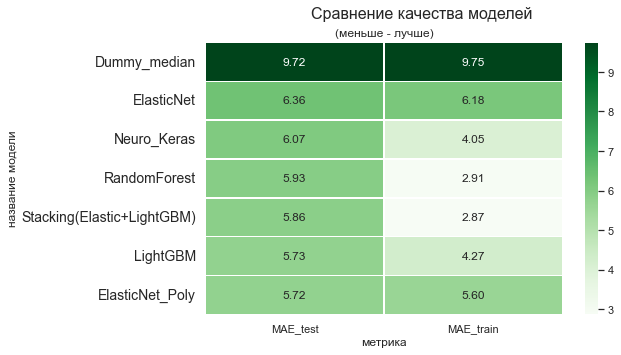

In [86]:
def heatmap_for_result (df,  cmap="Greens"):
    scaled_df = (df - df.min(axis=0))/(df.max(axis=0) - df.min(axis=0))
    sns.heatmap(df,  annot=df, fmt='.2f', linewidths=.5, cmap=cmap)

plt.figure(figsize=(8,5))
heatmap_for_result(df_model_result) 
plt.suptitle('Cравнение качества моделей', fontsize=16)
plt.yticks(rotation=0, fontsize=14)
plt.ylabel('название модели', fontsize=12)
plt.xlabel('метрика', fontsize=12)
plt.title('(меньше - лучше)', fontsize=12);

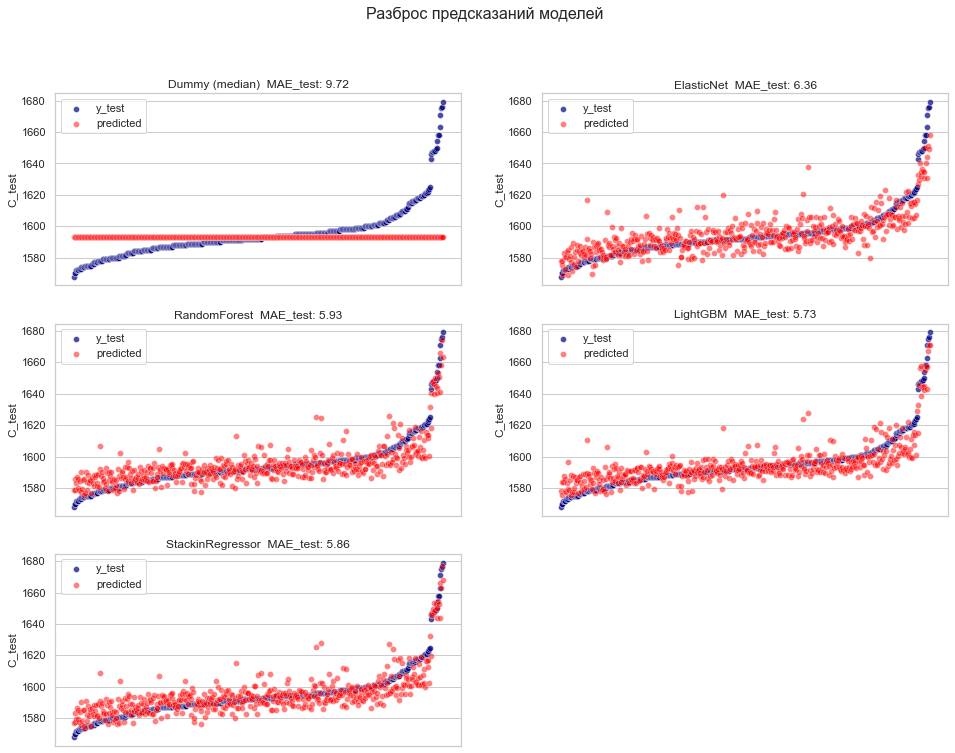

In [87]:
models_show()

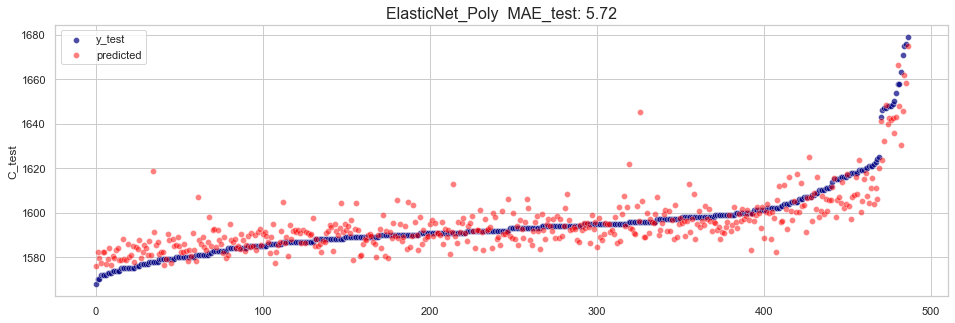

In [88]:
plot_predicted(y_test, X_test_poly, model_ElasticNet_Poly)    
plt.title('ElasticNet_Poly' + '  MAE_test: {:.2f}'.format(
            mean_absolute_error(y_test, model_ElasticNet_Poly.predict(X_test_poly))), fontsize=16);

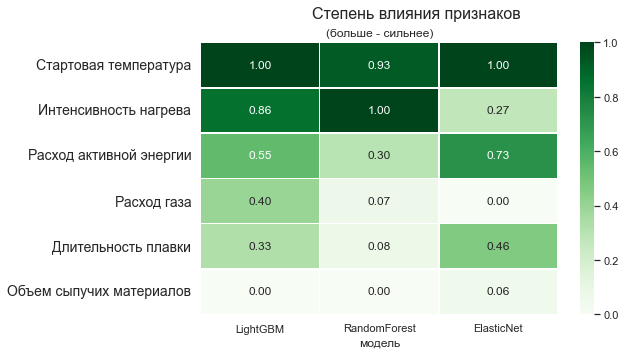

In [89]:
df_feature_importances = pd.DataFrame(index=X_train.columns,
                                     data={
                                    'LightGBM': model_lgbm.best_estimator_.feature_importances_,
                                    'RandomForest':   model_RandomForest.best_estimator_.feature_importances_,
                                    'ElasticNet':   np.abs(model_ElasticNet.best_estimator_.coef_),
                                    
                                     })

df_feature_importances = df_feature_importances.rename(
                                    {'C_start': 'Стартовая температура', 
                                    'duration': 'Длительность плавки',
                                    'real_power': 'Расход активной энергии',
                                    'power_intense': 'Интенсивность нагрева' , 
                                    'bulk_sum': 'Объем сыпучих материалов' ,
                                    'gas': 'Расход газа' })
                                               
df_feature_importances = df_feature_importances.sort_values(by='LightGBM', ascending=False)
df_feature_importances[:] = MinMaxScaler().fit_transform(df_feature_importances)

plt.figure(figsize=(8,5))
heatmap_for_result(df_feature_importances)
plt.suptitle('Степень влияния признаков', fontsize=16)
plt.yticks( rotation=0, fontsize=14)
#plt.ylabel('название признака', fontsize=12)
plt.xlabel('модель', fontsize=12)
plt.title('(больше - сильнее)', fontsize=12);

В разных моделях разные шкалы влияния, поэтому для сравнимости введена min-max нормализация коэффициентов.\
Полученная шкала от 0 (минимальное влияние) до 1 (максимальное)\
Модель полиноминальной регрессии дала хороший результат, но оценить вклад отдельных признаков сложнее.\
Наиболее сильные признаки независимо от модели : **стартовая температура и интенсивность нагрева.**

In [90]:
# X_test.merge((y_test - model_ElasticNet_Poly.predict(X_test_poly)), 
#              left_index=True, right_index=True).sort_values(by='C_finish')

## Выводы

**Лучшее качество достигнуто полиноминальной версией ElasticNet - 5.72**\
Идентичный результат дало использование LightGBM - 5.73\
Использование разных версий стэкинга себя не оправдало, это не дает существенного прироста точности.

- Наибольшее влияние на конечную температуру имеют первоначальная температура расплава и созданный признак интенсивности нагрева (отношение затраченной энергии к общей продолжительности плавки) **power_intense**
- Заявленную точность построенная модель обеспечивает во временном диапазоне плавки 6...95 мин. и температурах выше температуры плавления стали 1350 град.С.
- Добавление проволочных материалов оказывает минимальное влияние на процесс поэтому от учета этого фактора в модели решено отказаться. Возможно это связано со значительно большей массой расплава по сравнению с массой и эффектами от проволок.
- Сыпучие материалы поступающие из бункеров 12, 14, 15  испотзуются наиболее часто, имуют выраженную мультиколлинеарность между собой, остальные сыпучие материалы мало влияют на процесс, поэтому моделях введен обобщенный показатель массы добавленных сыпучих материалов **bulk_sum**
- Более 700 записей в датасете имеют только одно измерение температуры.


## Отчет по решению

**План проекта выполнен полностью.** Дополнительно к плану использованы две модели: StackingRegressor (стэкинг на основе ElasticNet, RandomForest, LightGBM) и полиноминальная регрессия на основе ElasticNet.

В первой версии проекта, несмотря на полученную хорошую метрику MAE 5.68, был пропущен анализ мулитиколлинеарности признаков. Была сделана соответствующая доработка.\
Самой трудоемкой частью оказалась проверка различных гипотез по созданию-отбору нужных признаков. Было проведено множество итераций по отбору различных комбинаций признаков, проверки их значимости и взаимной корреляции, подбору гиперпараметров моделей. Но это не сложности, это затраты времени.\
Сложности вызвала настройка рабочего места. Часть библиотек оказалась несовместима или не устанавливалась. Одновременно использовались платформы стационарный ПК на Win 10/Ubuntu 20.04, ноутбук macOS Big Sur для M1 и Яндекс.Практикум через браузер. Решение – разобрался и настроил.

**Ключевые этапы проекта:**

- 1. **Ознакомительный этап.**
    - 1.1. Ознакомление с доступной документацией о задаче, загрузка и первое знакомство с данными.
    - 1.2. Консультирование с тимлидом о целях, требуемых метриках и особенностям техпроцесса задачи.
- 2. **Основной этап**
    - 2.1. Создание концепции отбора-создания признаков на основе информации о  технологии процесса.
    - 2.2. Формирование базовой таблицы данных: объединение таблиц, фильтрация по временным меткам, создание набора дополнительных признаков для проверки разных гипотез.
    - 2.3. EDA анализ.
    - 2.4. Проверка корреляций с целевым параметром, мультиколлинеарности признаков и их отбор для модельного набора.
    - 2.5. Создание моделей предусмотренных планом, подбор гиперпараметров.
    - 2.6. Сравнение результатов разных моделей и важности признаков.
- 3. **Доработка и оформление.**
    - 3.1. После получения первых результатов проверка новых гипотез, создание дополнительных моделей, доработка в несколько итераций п.6-8
    - 3.2. Оформление работы и формулировка окончательных выводов.
- 4. **Согласование**
    - 4.1. Согласование работы с куратором, устранение замечаний, доработка.
    - 4.2. Согласование с тимлидом

**Итогом работы стали две модели:**
- полиноминальная регрессия **ElasticNet – MAE 5.72**
- модель ансамблевого  градиентного бустинга **LightGBM – MAE 5.73**
